# Classification. Linear models and KNN

In [31]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [33]:
from sklearn.exceptions import NotFittedError

In [34]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1 / (1 + np.exp(- X @ weights))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        return np.log(1 + np.exp(-x @ weights * y)).sum() / x.shape[0] \
                + np.sqrt((weights**2).sum()) / (2 * self.C)
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.  
        Return:
            train_losses: numpy array of shape (num_epochs,)
        """
        
        train_losses = []
        
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            train_losses.append(self.get_loss(X_ext, self.weights_, y))
            delta = -((X_ext.T * y) * (1 - 1 / (1 + np.exp((X_ext @ -self.weights_) * y)))).sum(axis=1) \
                        / X_ext.shape[0] + self.weights_ / self.C
            prev_weights = np.copy(self.weights_)
            self.weights_ -= self.eta * delta
            if np.sqrt(((self.weights_ - prev_weights)**2).sum()) < self.tol:
                break
        return np.array(train_losses)
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.where(self.predict_proba(X) > 0.5, 1, -1) 

In [35]:
from sklearn import datasets
from sklearn import metrics

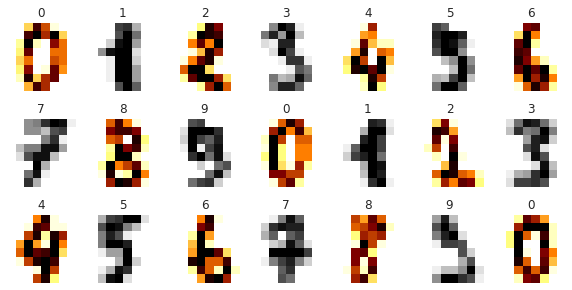

In [36]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [37]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [38]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test, return_losses=False):
    train_losses = clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    if return_losses:
        return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test), \
            train_losses
    else:
        return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test),

In [39]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [40]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [41]:
lr_clf.fit(X_train, y_train)

array([0.69314718])

In [42]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [43]:
model = CustomLogisticRegression()

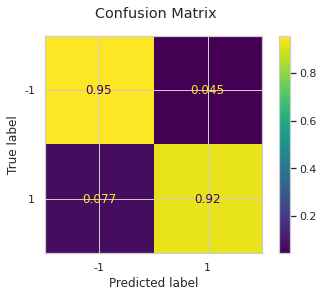

In [44]:
train_acc, test_acc, train_losses = fit_evaluate(model, X_train, y_train, X_test, y_test, return_losses=True)

In [45]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [46]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

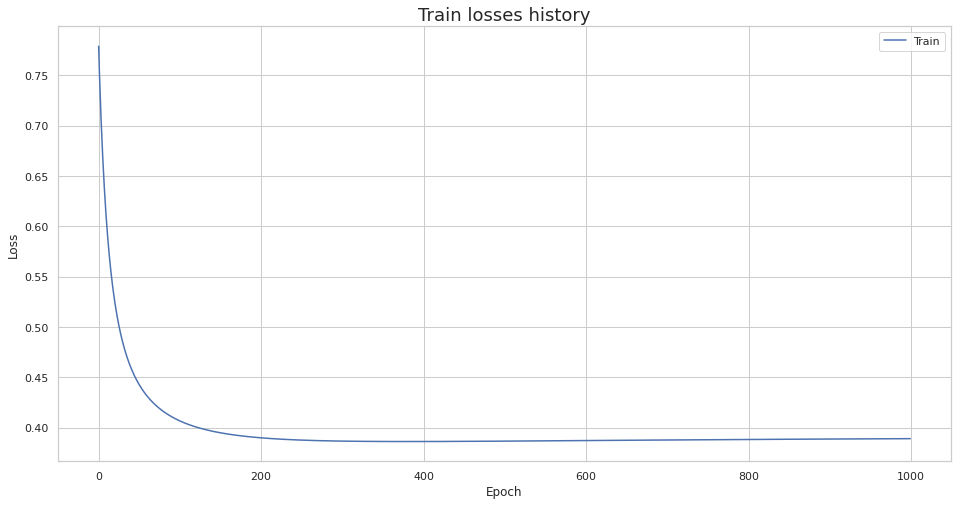

In [47]:
def visualize(data_arrays, title="Title", xlabel="X", ylabel="Y", labels=None):
    plt.figure(figsize=(16, 8))
    for data, label in zip(data_arrays, labels):
        plt.plot(data, label=label)
    plt.title(title, fontdict={"fontsize" : 18})
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

visualize([train_losses], "Train losses history", "Epoch", "Loss", ["Train"])

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

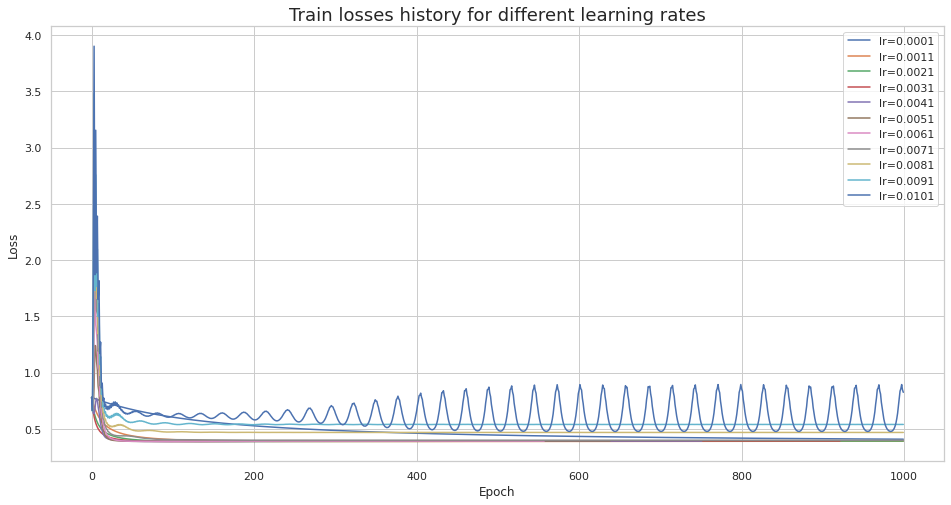

In [48]:
learning_rates = np.linspace(0.0001, 0.0101, 11)
diff_lr_losses_histories = []
for lr in learning_rates:
    diff_lr_losses_histories.append(CustomLogisticRegression(eta=lr).fit(X_train, y_train))

visualize(diff_lr_losses_histories, "Train losses history for different learning rates", 
          "Epoch", "Loss", labels=["lr=" + str(x) for x in learning_rates])

Let's check the behavior of the graph when epoch < 150

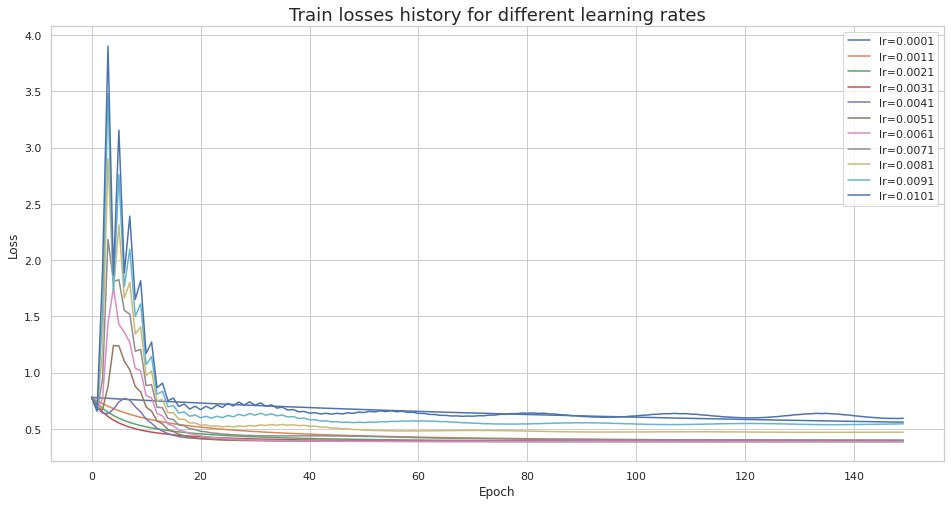

In [49]:
learning_rates = np.linspace(0.0001, 0.0101, 11)
diff_lr_losses_histories = []
for lr in learning_rates:
    diff_lr_losses_histories.append(CustomLogisticRegression(eta=lr).fit(X_train, y_train)[:150])

visualize(diff_lr_losses_histories, "Train losses history for different learning rates", 
          "Epoch", "Loss", labels=["lr=" + str(x) for x in learning_rates])

Of course, the learning rate affects the convergence. If it is small, then it converges slowly, if it is large, then it does not converge at all - we jump over the minimum and wander around it, as evidenced by these characteristic waves.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

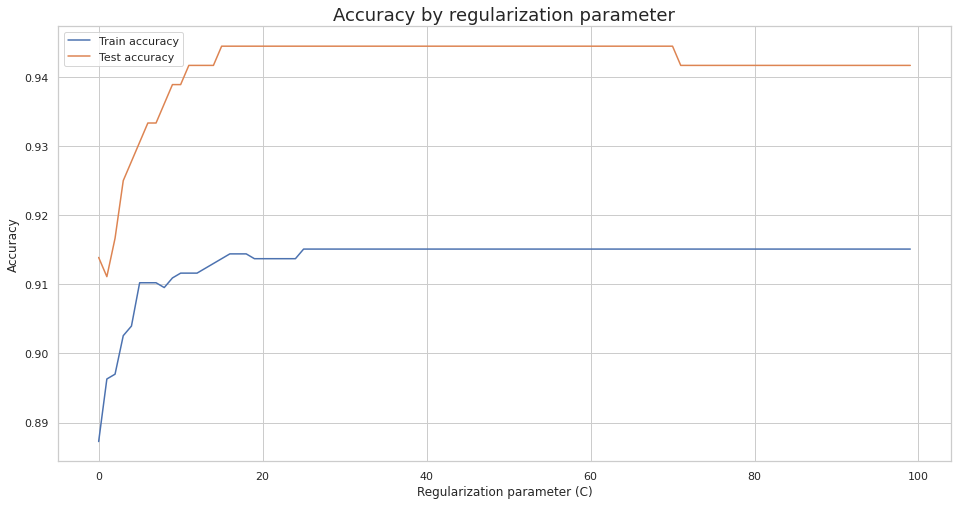

In [50]:
parameters = np.linspace(0.1, 10, 100)
train_accuracies, test_accuracies = [], []
for C in parameters:
    clf = CustomLogisticRegression(C=C)
    clf.fit(X_train, y_train)
    train_accuracies.append(metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train))
    test_accuracies.append(metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
visualize([train_accuracies, test_accuracies], "Accuracy by regularization parameter", 
          "Regularization parameter (C)", "Accuracy", labels=["Train accuracy", "Test accuracy"])

At first, the accuracy increases with the growth of the parameter C, then it remains approximately constant. Perhaps further, for large values ​​of the parameter, the regularization term has little effect on the gradient and that is why there is essentially no change

**(0.5 points)** Compare zero initialization and random initialization. 

### Zero initialization

,Train,Test
Accuracy,0.911621,0.938889


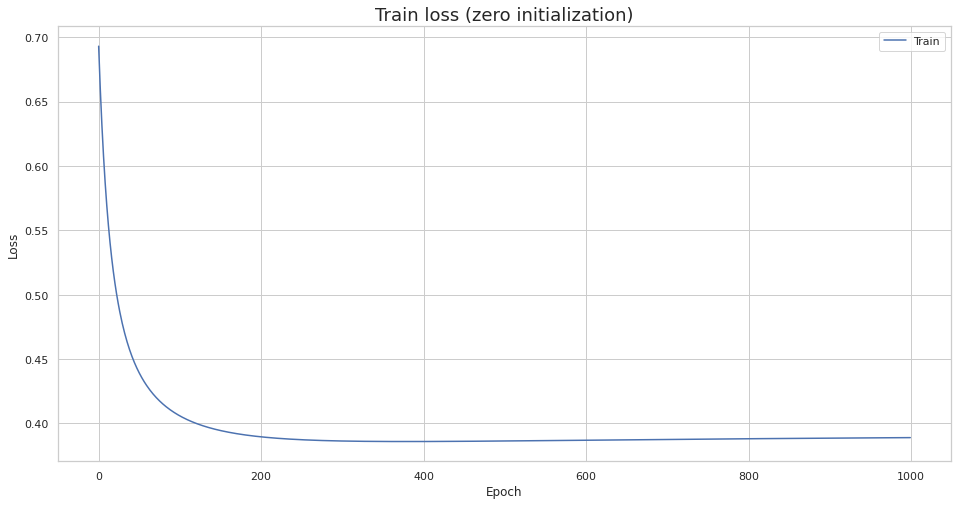

In [21]:
clf = CustomLogisticRegression(zero_init=True)
train_losses_zero = clf.fit(X_train, y_train)
train_accuracy_zero = metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train)
test_accuracy_zero = metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

display(pd.DataFrame({"Train" : train_accuracy_zero, "Test" : test_accuracy_zero}, 
                     index=["Accuracy"]))
visualize([train_losses_zero], "Train loss (zero initialization)", 
          "Epoch", "Loss", ["Train"])

### Random initialization

,Train,Test
Accuracy,0.910926,0.938889


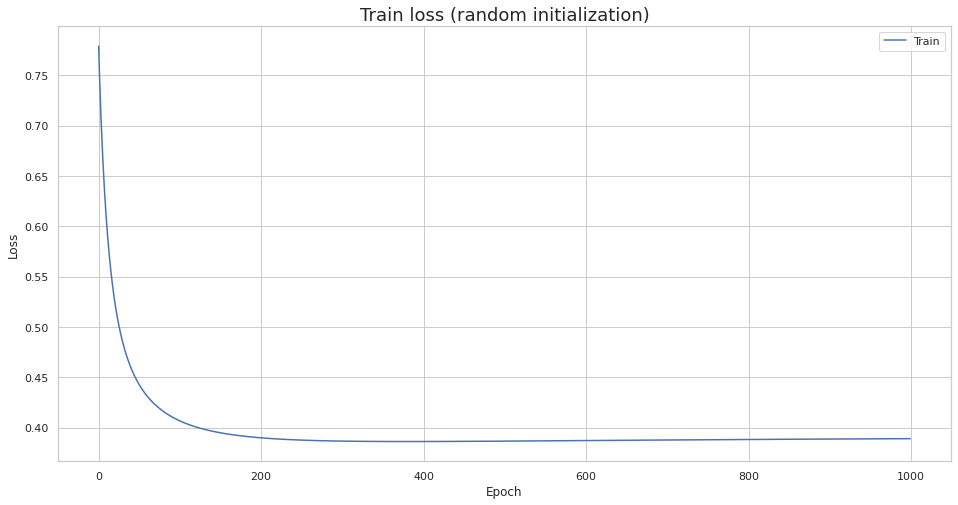

In [52]:
clf = CustomLogisticRegression()
train_losses_random = clf.fit(X_train, y_train)
train_accuracy_random = metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train)
test_accuracy_random = metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

display(pd.DataFrame({"Train" : train_accuracy_random, "Test" : test_accuracy_random}, 
                     index=["Accuracy"]))
visualize([train_losses_random], "Train loss (random initialization)", 
          "Epoch", "Loss", ["Train"])

It has almost no effect. Yes, with random initialization, optimization started with a larger loss value. But this is a matter of several iterations. The advantage of random initialization is the potential choice of a good starting point, which will lead to faster convergence

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [53]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return np.linalg.norm(X[:, None, :] - Y[None, :, :], axis=-1)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        sum_weights = []
        if hasattr(self, 'classes_'):
            for cls in self.classes_:
                sum_weights.append(weights[y==cls].sum())
        return np.array(sum_weights)
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / (P + self.eps)
            
            pos = P.argsort(axis=1)[:, :self.n_neighbors]
            w = np.array(list(map(lambda x: self.get_class_weights(x[0], x[1]),
                                  zip(self.y[pos], map(lambda x: x[0][x[1]], zip(weights_of_points, pos))))))
            return w / w.sum(axis=1).reshape(-1, 1)
                         
            
            #neighbors_labels = self.y[np.argsort(P, axis=1)][:, :self.n_neighbors]
            #neighbors_weights = np.sort(weights_of_points)[:, :self.n_neighbors]
            #print(neighbors_labels.shape, neighbors_weights.shape)
            #class_weights = []
            #for i in range(neighbors_labels.shape[0]):
            #    class_weights.append(self.get_class_weights(neighbors_labels[i], neighbors_weights[i]))
            #class_weights = np.array(class_weights)
            #print(class_weights.shape)
            #class_probs = class_weights / class_weights.sum(axis=1)[:, None]
            #print(class_probs.shape)
            #return class_probs
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return self.classes_[self.predict_proba(X).argmax(axis=1)]

In [54]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [55]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [56]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

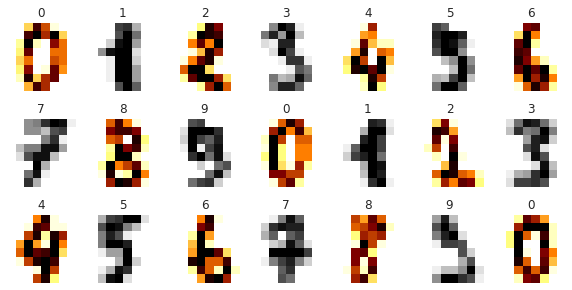

In [57]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [58]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [59]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

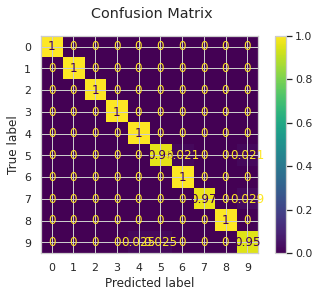

In [60]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [61]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [62]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [63]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

There is a metric that is better suited for this task, namely the `tangent metric`. It recognizes an image template given its location, rotation, and so on. After all, even in pictures that depict only numbers, they have a large Euclidean distance. Tangent metric solves this problem

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Suppose there is some company. And she provides some services. We have different data about the users of these services. And based on this data, we need to predict whether the user will continue to use it. Then we can use KNN and the Euclidean distance metric for this. It would be appropriate to normalize the features. Normalization will bring the features to approximately the same distribution and this may well guarantee an equal contribution of each feature (so that the scale does not affect). Or you can use a weighted Euclidean metric, in which the weights will indicate the importance of a particular feature (if this importance is known). 

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [54]:
PATH = "./data/"

In [55]:
data = pd.read_csv(os.path.join('train.csv')).set_index('PassengerId')

In [56]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

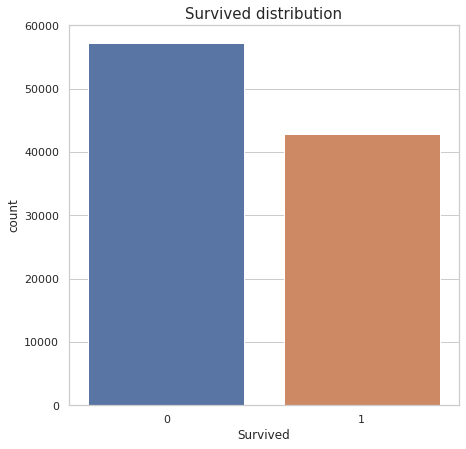

In [57]:
fig = plt.figure(figsize=(7, 7))
sns.countplot(x=data["Survived"]);
plt.title("Survived distribution", {"fontsize": 15});

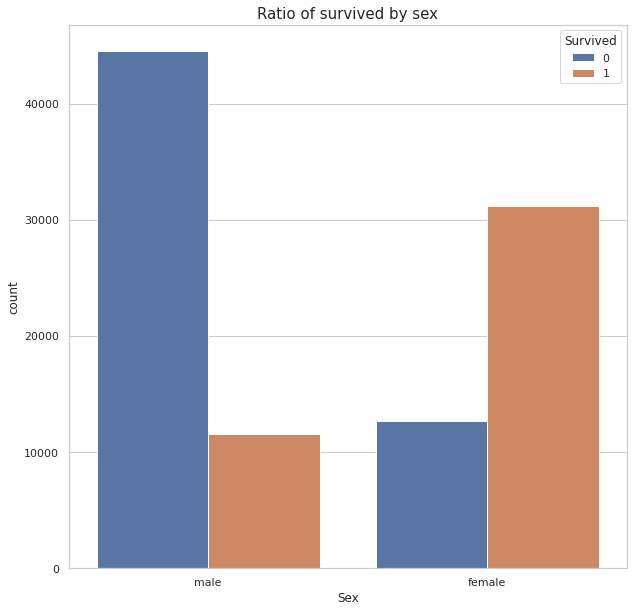

In [58]:
fig = plt.figure(figsize=(10, 10))
sns.countplot(x="Sex", hue="Survived", data=data);
plt.title("Ratio of survived by sex", {"fontsize": 15});

Сlasses as a whole are not unbalanced. Most of the survivors are women

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

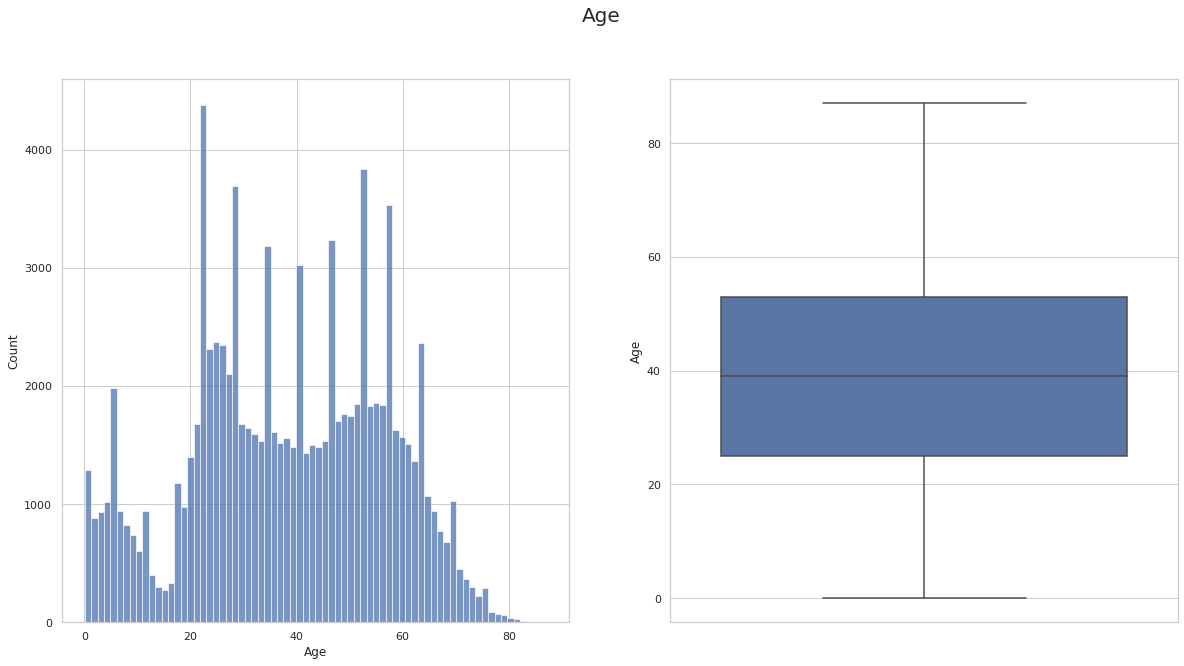

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Age', fontsize=20)

sns.histplot(ax=axes[0], data=data, x="Age");
sns.boxplot(ax=axes[1], data=data, y="Age");

In [60]:
data["Age"].describe()

count    96708.000000
mean        38.355472
std         18.313556
min          0.080000
25%         25.000000
50%         39.000000
75%         53.000000
max         87.000000
Name: Age, dtype: float64

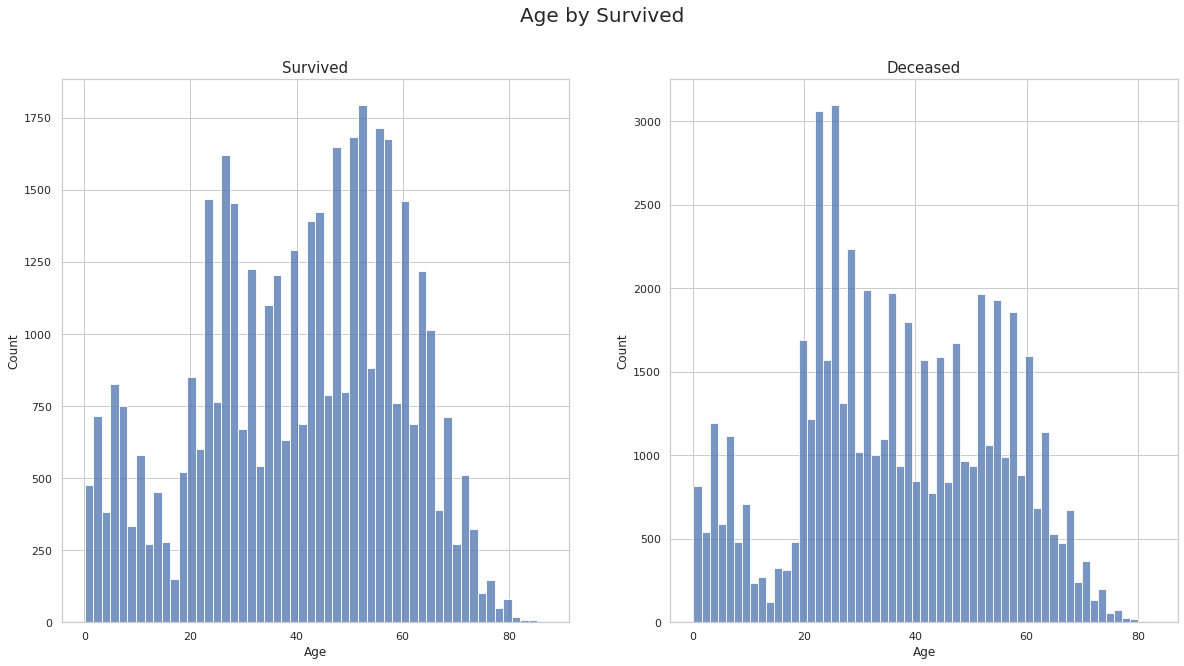

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Age by Survived', fontsize=20)

sns.histplot(ax=axes[0], data=data[data["Survived"] == 1], x="Age");
axes[0].set_title("Survived",{"fontsize": 15});
sns.histplot(ax=axes[1], data=data[data["Survived"] == 0], x="Age");
axes[1].set_title("Deceased",{"fontsize": 15});

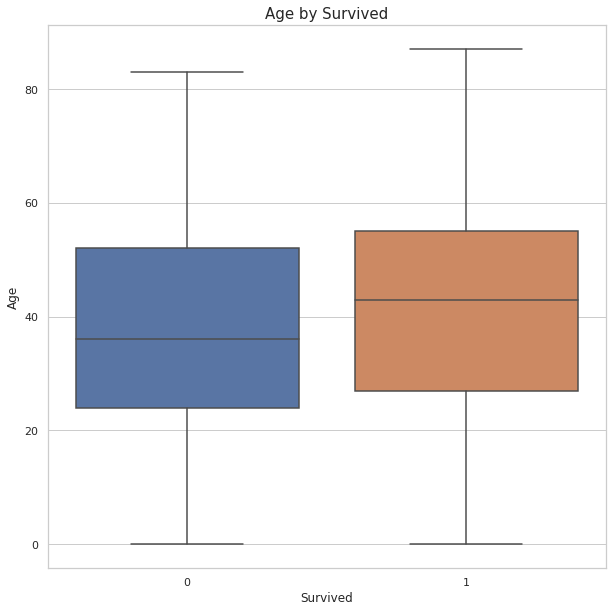

In [62]:
fig = plt.figure(figsize=(10, 10))
sns.boxplot(x="Survived", y="Age", data=data);
plt.title("Age by Survived", {"fontsize": 15});

In [63]:
data.groupby("Survived")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,55290.0,36.708695,17.809058,0.08,24.0,36.0,52.0,83.0
1,41418.0,40.553799,18.742172,0.08,27.0,43.0,55.0,87.0


The statistics are given in the tables. The distribution varies slightly depending on survival. The mean and median age of survivors is greater than that of those who died. This is most likely due to the fact that older people earned more and sailed in a higher passenger class.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

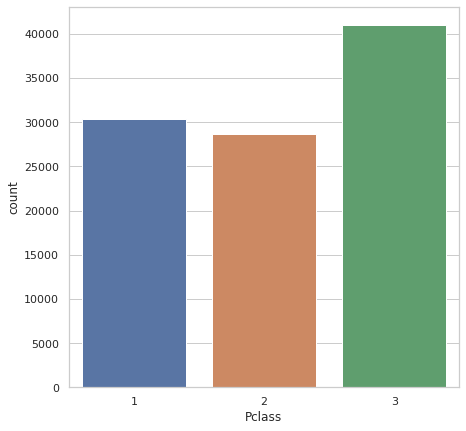

In [64]:
plt.figure(figsize=(7, 7))
sns.countplot(x=data["Pclass"]);

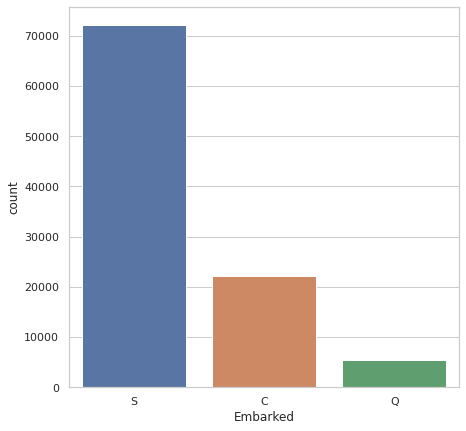

In [65]:
plt.figure(figsize=(7, 7))
sns.countplot(x=data["Embarked"]);

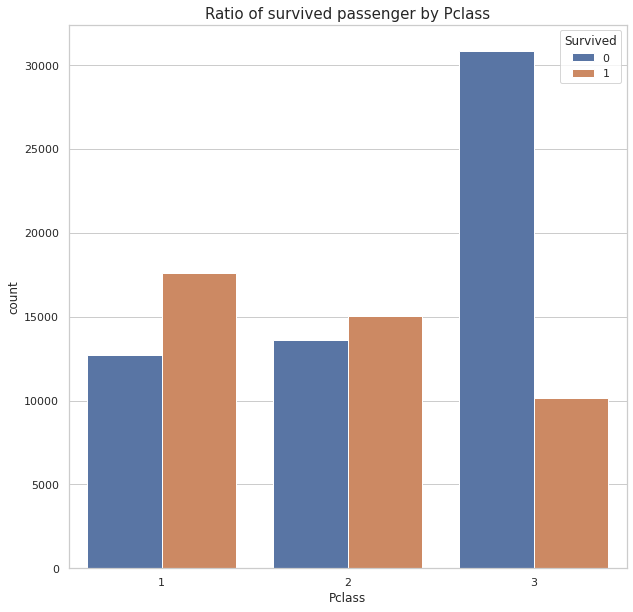

In [66]:
fig = plt.figure(figsize=(10, 10))
sns.countplot(x="Pclass", hue="Survived", data=data);
plt.title("Ratio of survived passenger by Pclass", {"fontsize": 15});

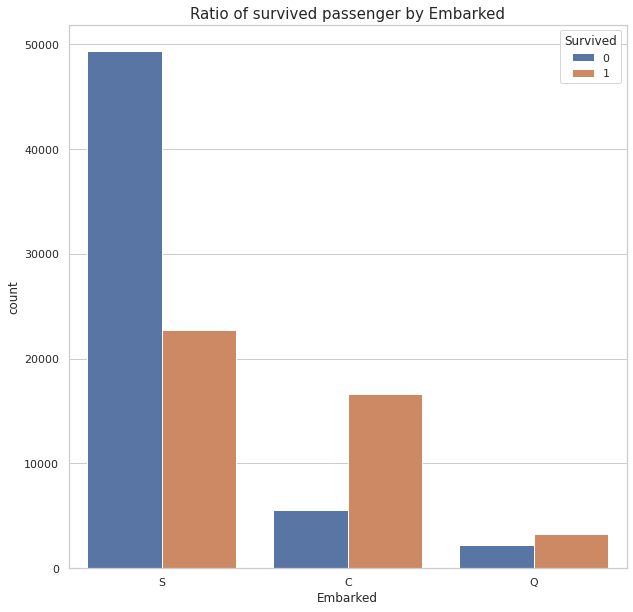

In [67]:
fig = plt.figure(figsize=(10, 10))
sns.countplot(x="Embarked", hue="Survived", data=data);
plt.title("Ratio of survived passenger by Embarked", {"fontsize": 15});

As we can see, there are far fewer survivors among third-class passengers than among first and second. The first class is "the safest". In percentage terms, Port Southampton has more deceased than other ports

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [68]:
data.isna().sum() / data.shape[0] * 100

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

In [69]:
data.shape

(100000, 11)

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

We can fill in these gaps with the median or mean, for example. The downside to this approach is that it's actually a bit of an artificial padding that may not be true. The advantage is that we won't lose information from columns that have it. The second option is to simply drop data with gaps. The disadvantage of this approach is the loss of potentially useful data, and the advantage that we do not add the above artificiality

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [70]:
numeric_features = ["Age", "Fare"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

to_drop = ["Cabin", "Ticket", "Name"]

categorical_features = ["Embarked", "Sex", "Pclass"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("drop", "drop", to_drop)
    ]
)

In [71]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [77]:
preprocessed_data = preprocessor.fit_transform(data)
preprocessed_data.shape
np.isnan(preprocessed_data).sum()

0

In [85]:
target = "Survived"
features = data.columns[data.columns != target]
X = data[features]
y = data[target].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [86]:
X_train.shape, X_test.shape

((80000, 10), (20000, 10))

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [88]:
logreg = LogisticRegression(max_iter=1000)
parameters = {"logreg__C" : [0.1, 0.2, 0.5, 1, 2, 5, 10]}
clf = GridSearchCV(Pipeline([("preprocessor", preprocessor), 
                            ("logreg", logreg)]), 
                   parameters, scoring="accuracy", cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                  

In [89]:
pd.DataFrame({"Train" : metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), 
             "Test" : metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)}, 
            index=["Accuracy"])

,Train,Test
Accuracy,0.762025,0.75975


In [91]:
knn = KNeighborsClassifier()
parameters = {"knn__n_neighbors" : [x for x in range(1, 10, 2)], 
             "knn__weights" : ["distance", "uniform"], 
             "knn__p" : [1, 2]}
clf_knn = GridSearchCV(Pipeline([("preprocessor", preprocessor),
                                 ("scal", StandardScaler()),
                                ("knn", knn)]),
                   parameters, scoring="accuracy", cv=5)
clf_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                  

In [92]:
pd.DataFrame({"Train" : metrics.accuracy_score(y_pred=clf_knn.predict(X_train), y_true=y_train), 
             "Test" : metrics.accuracy_score(y_pred=clf_knn.predict(X_test), y_true=y_test)}, 
            index=["Accuracy"])

,Train,Test
Accuracy,0.793525,0.7553


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [93]:
test_data = pd.read_csv(os.path.join('test.csv')).set_index('PassengerId')
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


In [96]:
knn_best = clf_knn.best_estimator_
knn_best.fit(X, y)
predicted = knn_best.predict(test_data)

In [98]:
predicted

array([0, 1, 1, ..., 0, 1, 1])

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [104]:
submission = pd.read_csv('sample_submission.csv')
submission["Survived"] = predicted
submission.to_csv("submission.csv", index=False)

In [105]:
submission.head()

,PassengerId,Survived
0,100000,0
1,100001,1
2,100002,1
3,100003,0
4,100004,1


Kaggle Score: 0.75786